In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [34]:
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')

#### Now, attempt to find some completeness limits?

In [152]:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar

def remove_inf(data):
    data[np.isfinite(data) == False] = -999
    return data

mass_total = remove_inf(mendel_masses['bulge+disc'])
has_mass = mass_total > 0
print('{}/{} have masses!'.format(has_mass.sum(),len(has_mass)))

galaxy_table = Table()
galaxy_table['mass'] = mass_total[has_mass]
Mr = np.array(gz2_data['PETROMAG_MR'],dtype='float64')[has_mass]
Lr = lum_to_solar(Mag_to_lum(Mr,6185.19))
galaxy_table['Mr'] = Mr
galaxy_table['Lr'] = Lr
galaxy_table['u-r'] = (gz2_data['PETROMAG_MU'] 
                     - gz2_data['PETROMAG_MR'])[has_mass]
galaxy_table['M/L'] = galaxy_table['mass'] - galaxy_table['Lr']
galaxy_table['redshift'] = gz2_data['REDSHIFT_1'][has_mass]

237996/248883 have masses!


0.31428331924


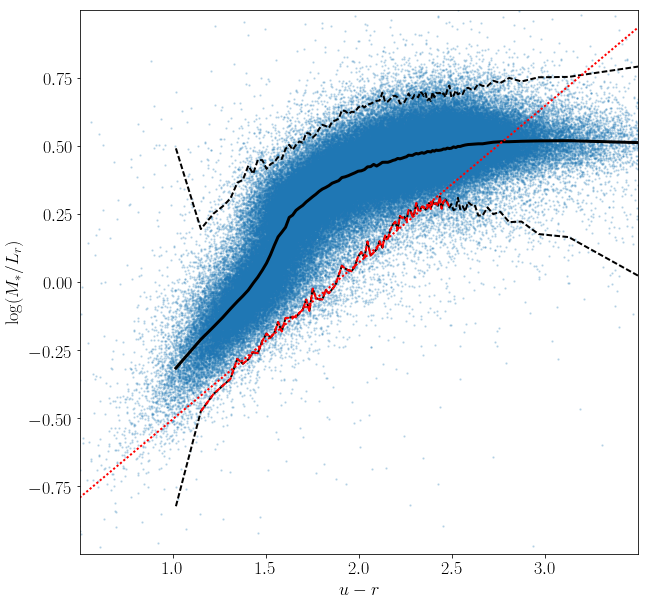

In [180]:
from bin_statistics import assign_bins
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

def log(x,m,c):
    return m*np.log10(x) + c

def exp(x,m,c):
    return m*np.exp(-x) + c

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

x = galaxy_table['u-r']
y = galaxy_table['M/L']

_ = ax.scatter(x,y,s=2,alpha=0.2)
_ = ax.set_xlim(0.5,3.5)
_ = ax.set_ylim(-1,1)
_ = ax.set_xlabel('$u-r$')
_ = ax.set_ylabel('$\log(M_*/L_r)$')

xbins = assign_bins(x,equal_N=True,N_bins=100)

y01 = []
y50 = []
y99 = []
x50 = []

for b in np.unique(xbins):
    in_bin = xbins == b
    x_b = x[in_bin]
    y_b = y[in_bin]
    x50.append(np.percentile(x_b,50))
    y01.append(np.percentile(y_b,1))
    y50.append(np.percentile(y_b,50))
    y99.append(np.percentile(y_b,99))
    
_ = ax.plot(x50,p01,'k--',lw=2)
_ = ax.plot(x50,p50,'k-',lw=3)
_ = ax.plot(x50,p99,'k--',lw=2)

x50_subset = x50[1:-20]
y01_subset = y01[1:-20]
_ = plt.plot(x50_subset,y01_subset,'r--',lw=2)
p, _ = curve_fit(linear,x50_subset,y01_subset)

x_g = np.linspace(0.5,3.5,100)
_ = plt.plot(x_g,linear(x_g,*p),'r:',lw=2)

In [193]:
from astropy.cosmology import FlatLambdaCDM

from luminosities_magnitudes_and_distances import mag_to_Mag

def get_mass_limit(data,z_limit,mag_limit,mass_equation,low_z_limit=None,
                   column_names=['redshift','Mr'],colour_column='u-r',Mag_sun=4.67):

    z_column, Mag_column = column_names
    colour = data[colour_column]
    
    if low_z_limit != None:
        in_z_min = data[z_column] >= low_z_limit
    else:
        in_z_min = np.full(len(data), True, dtype=bool)
    
    Mag_limit = mag_to_Mag(mag_limit,z_limit)
    in_z_max = data[z_column] <= z_limit
    in_Mag_limit = data[Mag_column] <= Mag_limit
    in_volume_limit = (in_z_min) & (in_z_max) & (in_Mag_limit)
    vl_colour = colour[in_volume_limit]
    colour_99 = np.percentile(vl_colour,99)#,axis=0)
    log_ML = mass_equation(colour_99)
    lum_limit = 10**lum_to_solar(Mag_to_lum(Mag_limit,6185.19))
    mass_limit = lum_limit*(10**(log_ML))
    logmass = math.log10(mass_limit)
    return logmass

def get_sample_limits(z_limit,mag_limit,color=0.75):
    D_max = (10**6)*(np.array(cosmo.luminosity_distance([z_limit]))[0])
    #k_val = calc_kcor('r',z_limit,'g - r',color) # value of 0.75 is arbitrarily selected here!
    M_limit = mag_limit - 5*(math.log10(D_max) - 1) #- k_val
    return M_limit

def mass_equation(x):
    y = linear(x,*p)
    ymax = np.max(y01)
    if y > ymax:
        return ymax
    else:
        return y

z_limits = np.linspace(0.03,0.1,71)
mass_limits = []

for z_limit in z_limits:
    lower_mass_limit = get_mass_limit(galaxy_table,z_limit,17,mass_equation)
    upper_mass_limit = get_mass_limit(galaxy_table,z_limit,14,mass_equation)

IndexError: cannot do a non-empty take from an empty axes.

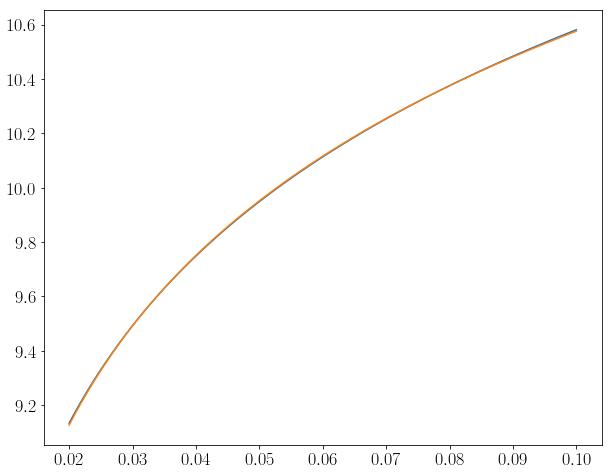

In [187]:
def log_function(x,m,c):
    return m*np.log10(x) + c

_ = plt.plot(z_limits,mass_limits)



p_mass, _ = curve_fit(log_function,z_limits,mass_limits)
x_g = np.linspace(0.02,0.1,1000)
_ = plt.plot(x_g,log_function(x_g,*p_mass))

In [188]:
print(p_mass)

[  2.07355465  12.64930538]


In [ ]:
_ = plt.plot(mass_equation)